This notebook describes how to implement SIRT using tomosipo. 

Given the tomographic inverse problem
$$ A x = y, $$
The SIRT algorithm updates it's estimate $x$ iteratively as follows:
$$    x_{i+1} = x_i + C  A^T R  (y - A x_i). $$

Here, $R$ and $C$ are diagonal matrices containing the row and column sums of $A$, respectively. 

For more information, see https://tomroelandts.com/articles/the-sirt-algorithm

In [6]:
import tomosipo as ts
import cupy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(height=3, cmap="gray", clim=(-.5, 1.5), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        pcm = ax.imshow(v.get().squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()



Compiling kernel RayDrivenConeFP with arguments {'slices_per_block': 64, 'rows_per_block': 64, 'cols_per_block': 64, 'nr_projs_global': 1024, 'volume_axes': (0, 1, 2), 'projection_axes': (1, 0, 2)}...
Compiling kernel VoxelDrivenConeBP with arguments {'voxels_per_block': (6, 32, 16), 'nr_projs_block': 32, 'nr_projs_global': 1024, 'texture': 'tex3D', 'volume_axes': (0, 1, 2), 'projection_axes': (1, 0, 2)}...


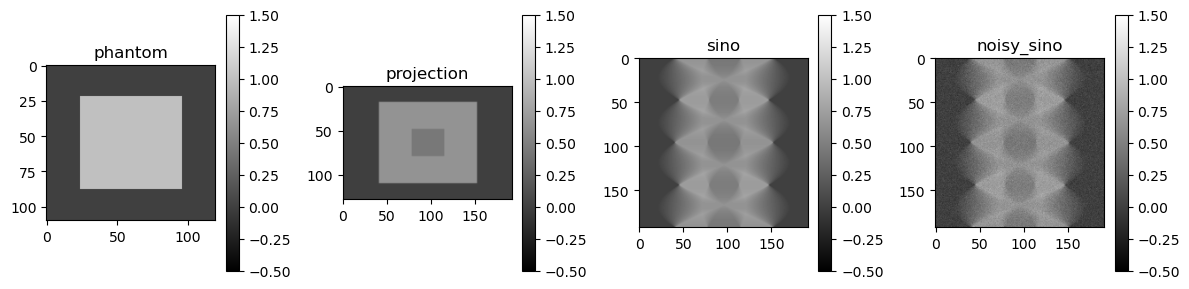

In [2]:
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
N = 128
full_vg = ts.volume(size=(1.0, 1.1, 1.2), shape=(100, 110, 120))
SOD = 200
SDD = 1.2 * SOD
full_pg = ts.cone(angles=3 * N // 2, shape=(N, 3 * N // 2), size=(1, 1.5),
                  src_orig_dist=SOD, src_det_dist=SDD)

A_tb = ts.operator(full_vg, full_pg)
phantom = cp.asarray(ts.phantom.hollow_box(ts.data(full_vg)).data)
sino = A_tb(phantom)
noisy_sino = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                        dtype=cp.float32)
plot_imgs(
    phantom=phantom[64],       # central axial slice
    projection=sino[:, 0, :],  # first projection image
    sino=sino[64, ...],        # sinogram of central slice
    noisy_sino=noisy_sino[64, ...], # noisy sinogram
)    

In [13]:
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
A_kk = ts.operator(full_vg, full_pg, backend='kernelkit')
for A in A_kk, A_tb:
    print(f"{A.__class__.__name__}:")
    sino = A(phantom)
    noisy_sino = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                            dtype=cp.float32)
    for _ in tqdm(range(100)):
        x = A.T(noisy_sino)
        cp.cuda.Device(0).synchronize()
        
    for _ in tqdm(range(100)):
        sino = A(phantom)
        cp.cuda.Device(0).synchronize()

Compiling kernel RayDrivenConeFP with arguments {'slices_per_block': 64, 'rows_per_block': 64, 'cols_per_block': 64, 'nr_projs_global': 1024, 'volume_axes': (0, 1, 2), 'projection_axes': (1, 0, 2)}...
Compiling kernel VoxelDrivenConeBP with arguments {'voxels_per_block': (6, 32, 16), 'nr_projs_block': 32, 'nr_projs_global': 1024, 'texture': 'tex3D', 'volume_axes': (0, 1, 2), 'projection_axes': (1, 0, 2)}...
KernelkitOperator:


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Operator:


100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


Operator:


100%|██████████| 200/200 [00:08<00:00, 24.59it/s]


<Figure size 640x480 with 0 Axes>

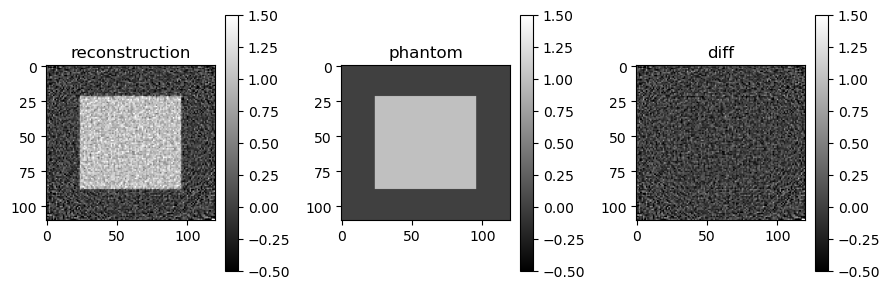

KernelkitOperator:


100%|██████████| 200/200 [00:06<00:00, 29.66it/s]


<Figure size 640x480 with 0 Axes>

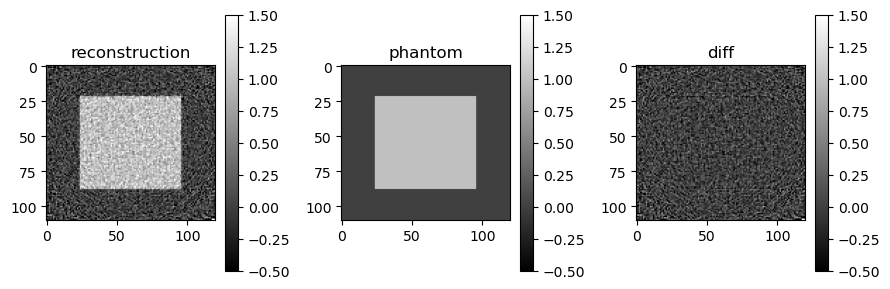

In [15]:
for A in (A_tb, A_kk):
    print(f"{A.__class__.__name__}:")
    y = noisy_sino
    x_cur = cp.zeros(A.domain_shape, dtype=cp.float32)

    y_tmp = cp.ones_like(y)
    C = 1.0 / A.T(y_tmp)
    C[C == cp.infty] = 0.0

    x_tmp = cp.ones_like(x_cur)
    R = 1.0 / A(x_tmp)
    R[R == cp.infty] = 0.0

    num_iters = 200
    for i in tqdm(range(num_iters)):
        A(x_cur, out=y_tmp)
        y_tmp -= y    # flip sign here
        y_tmp *= R
        A.T(y_tmp, out=x_tmp)
        x_tmp *= C
        x_cur -= x_tmp # flip sign here
        
    plt.figure()
    plot_imgs(
        reconstruction=x_cur[64], 
        phantom=phantom[64],
        diff=(x_cur - phantom)[64],
    )
    plt.show()

In [5]:
from kernelkit.algo import sirt

pg = A_kk.kernelkit_op.projector.projection_geometry
vg = A_kk.kernelkit_op.projector.volume_geometry
sino = A_kk(phantom)
y = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                        dtype=cp.float32)
sirt(y, pg, vg, iters=100, residual_every=None)


ValueError: Number of projections does not match number of geometries.